# Compiling the building footprints of Electrical substations (onderstations)

The objective of this notebook is to compile a data set consisting of electrical substation footprints as a supporting solution for lvc reconstructor and path-finder problem.

The operationalization consists of 3 phases:
- pre-fine-tuning -> (auto) extracting and tuning footprints given poi, distance and power cables
- in-fine-tuning -> (auto) tuning given poi and threshold
- post-fine-tuning -> (manually) tuning as in supervised fashion

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pyproj
import osmnx as ox
import tqdm
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from pathlib import Path
import os

/var/folders/bh/hhr2wkwn2ldcpz5w4tgn7sb80000gn/T/ipykernel_29256/822702907.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
ROOT = Path(os.getcwd()).parent.parent
DATA_ATOM = os.path.join(ROOT, 'data', 'atom')
DATA_LIANDER = os.path.join(ROOT, 'data', 'liander')

In [3]:
CRS = 4326

stations = gpd.read_parquet(Path(DATA_ATOM, 'stations.parquet'))
stations = stations.to_crs(pyproj.CRS.from_epsg(CRS))
stations.head()

,id,station,netbeheerder,status,totaleCapaciteitInvoedingMva,totaleCapaciteitAfnameMva,beschikbareCapaciteitInvoedingHuidigMva,beschikbareCapaciteitAfnameHuidigMva,verwachtJaarVanOverbelastingInvoeding,verwachtJaarVanOverbelastingAfname,...,peildatum,beschikbareCapaciteitAfname3JaarMvaVisualisatie,beschikbareCapaciteitAfname5JaarMvaVisualisatie,beschikbareCapaciteitAfname10JaarMvaVisualisatie,beschikbareCapaciteitAfnameHuidigMvaVisualisatie,beschikbareCapaciteitInvoeding3JaarMvaVisualisatie,beschikbareCapaciteitInvoeding5JaarMvaVisualisatie,beschikbareCapaciteitInvoeding10JaarMvaVisualisatie,beschikbareCapaciteitInvoedingHuidigMvaVisualisatie,geometry
0,stations.34bda653-e4ae-4a3b-9399-c59f9f730745,Krimpen_Langeland 50 kV,Stedin,Bestaand,117.0,117.0,142.0,12.0,2050,2026,...,2022-10-18,0,0,0,12,0,0,0,142,POINT (4.62915 51.91080)
1,stations.b3b5f7d2-8fb9-4b44-9fe8-cdecd171eceb,Rotterdam Ommoord 25 kV,Stedin,Bestaand,115.0,115.0,157.0,-30.0,2050,2050,...,2022-10-18,0,0,0,0,149,148,142,157,POINT (4.52947 51.95541)
2,stations.57fc548f-9089-4e24-ab62-7555f0035b4b,Gouda Ijsseldijk 50 kV,Stedin,Bestaand,200.0,200.0,185.0,48.0,2045,2035,...,2022-10-18,22,13,0,48,203,176,121,185,POINT (4.73411 52.00775)
3,stations.600e067d-26f2-4f1a-944b-54d47534ba72,Delft 1 25 kV,Stedin,Bestaand,187.0,187.0,205.0,46.0,2050,2027,...,2022-10-18,15,4,0,46,201,191,160,205,POINT (4.36754 51.98904)
4,stations.5c7d27cc-871e-4c39-aa64-2186cb674d25,Grindweg 25 kV,Stedin,Bestaand,40.0,40.0,48.0,5.0,2050,2026,...,2022-10-18,3,0,0,5,38,36,30,48,POINT (4.49639 51.96228)


In [4]:
verzorgingsgebied = gpd.read_parquet(Path(DATA_ATOM, 'verzorgingsgebied.parquet'))
verzorgingsgebied = verzorgingsgebied.to_crs(CRS)
verzorgingsgebied.head()

,id,station,netbeheerder,status,totaleCapaciteitInvoedingMva,totaleCapaciteitAfnameMva,beschikbareCapaciteitInvoedingHuidigMva,beschikbareCapaciteitAfnameHuidigMva,verwachtJaarVanOverbelastingInvoeding,verwachtJaarVanOverbelastingAfname,...,peildatum,beschikbareCapaciteitAfname3JaarMvaVisualisatie,beschikbareCapaciteitAfname5JaarMvaVisualisatie,beschikbareCapaciteitAfname10JaarMvaVisualisatie,beschikbareCapaciteitAfnameHuidigMvaVisualisatie,beschikbareCapaciteitInvoeding3JaarMvaVisualisatie,beschikbareCapaciteitInvoeding5JaarMvaVisualisatie,beschikbareCapaciteitInvoeding10JaarMvaVisualisatie,beschikbareCapaciteitInvoedingHuidigMvaVisualisatie,geometry
0,indicatief_verzorgingsgebied.3f7b1732-778d-4b1...,Wittevrouweveld,Enexis,Bestaand,35,35,34.0,10.0,2028,2035,...,2022-12-14,10,10,10,10,34,34,34,34,"MULTIPOLYGON (((5.66455 50.83226, 5.70274 50.8..."
1,indicatief_verzorgingsgebied.0a727e27-ba60-487...,Boschpoort,Enexis,Bestaand,45,45,6.0,23.0,2023,2035,...,2022-12-14,23,23,23,23,6,6,6,6,"MULTIPOLYGON (((5.64897 50.82704, 5.64918 50.8..."
2,indicatief_verzorgingsgebied.ed973a51-edcc-40e...,Heer,Enexis,Bestaand,40,40,38.0,0.0,2028,2023,...,2022-12-14,0,0,0,0,38,38,38,38,"MULTIPOLYGON (((5.83113 50.75886, 5.83102 50.7..."
3,indicatief_verzorgingsgebied.9e164099-7d30-41a...,Schoonbron,Enexis,Bestaand,45,47,0.0,0.0,2023,2023,...,2022-12-14,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((5.91508 50.75040, 5.91508 50.7..."
4,indicatief_verzorgingsgebied.adc9060f-a6b2-4dd...,Terwinselen,Enexis,Bestaand,110,116,0.0,0.0,2023,2023,...,2022-12-14,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((6.05465 50.92368, 6.05450 50.9..."


In [5]:
ms = gpd.read_parquet(Path(DATA_LIANDER, 'middenspanningskabels.pyarrow'))
ms = ms.to_crs(pyproj.CRS.from_epsg(CRS))
ms = pd.concat([ms, ms.bounds], axis=1)
ms.head()

,id,geometry,minx,miny,maxx,maxy
0,10255800,"LINESTRING (5.71308 51.93644, 5.71308 51.93644...",5.713075,51.936441,5.716208,51.936871
1,10255816,"LINESTRING (5.55664 51.92032, 5.55665 51.92031...",5.555937,51.919655,5.556735,51.920319
2,10255842,"LINESTRING (5.51975 51.94033, 5.51987 51.94030...",5.519753,51.939955,5.521645,51.940371
3,10255858,"LINESTRING (5.52608 51.96371, 5.52661 51.96372...",5.526082,51.963712,5.526847,51.964128
4,10255872,"LINESTRING (5.75006 51.90587, 5.75009 51.90582...",5.750056,51.901774,5.752254,51.905867


# - Phase 1

## Retrieve the building footprint of the substations

Retrieve pre-building footprints given geocode and distance

In [6]:
%%time
%%capture

import warnings

warnings.filterwarnings('ignore')

foot_prints = []

for idx in range(len(stations)):
    sample = stations.iloc[idx, -1]
    coords = sample.coords
    poi = (coords[0][1], coords[0][0])
    foot_print = ox.geometries_from_point(poi, {"building": True}, dist=160)
    foot_prints.append(foot_print)

CPU times: user 7.76 s, sys: 567 ms, total: 8.33 s
Wall time: 8.88 s


When storing the data to avoid API calls is desired, this can be achieved as shown in the code block below

In [ ]:
# Storing the data in order to avoid API calls can be appreciated
# FOOTPRINTS = os.path.join(Path(os.getcwd()).parent, 'footprints')

# Store the data in order to avoid API calls
# np.savez_compressed(os.path.join(FOOTPRINTS, 'data_footprints'), foot_prints_data=foot_prints)

# When stored, the data can be read as follows
# foot_prints = np.load(os.path.join(FOOTPRINTS, 'data_footprints.npz'), allow_pickle=True)

## Design Algorithm for determining the footprints

In [10]:
1e-2

0.01

In [21]:
%%time

import warnings

warnings.filterwarnings('ignore')

tuned_footprints = {}
EXPAND = 1e-2

stop = False

for idx in tqdm.tqdm_notebook(range(len(foot_prints))):
    foot_print = foot_prints[idx]

    if foot_print.size == 0:
        continue

    area_of_interest = unary_union(foot_print.geometry)
    minx, miny, maxx, maxy = area_of_interest.bounds

    minx -= EXPAND
    miny -= EXPAND
    maxx += EXPAND
    maxy += EXPAND

    # faster computation utilizing union + min, max strategy
    aoi_lines = ms[(ms.minx >= minx) & (ms.miny >= miny) & (ms.maxx <= maxx) & (ms.maxy <= maxy)]
    osmids = foot_print.reset_index()['osmid']

    tmp_foot_print_wrapper = dict()
    tmp_foot_print_wrapper['osmids'] = []
    tmp_foot_print_wrapper['geometries'] = []
    tmp_foot_print_wrapper['union'] = None
    tmp_foot_print_wrapper['cable_ms_idx'] = []

    for building_idx in range(len(foot_print)):

        building = foot_print.iloc[building_idx]
        d = building.geometry.distance(aoi_lines.geometry)

        # using np.array to solve array float issue caused by changing return type <class 'pandas.core.series.Series'> + <class 'geopandas.geoseries.GeoSeries'>
        d_idx = d[np.array(d) <= 3e-6].index

        if len(d_idx) > 0:
            tmp_foot_print_wrapper['geometries'].append(building.geometry)
            tmp_foot_print_wrapper['osmids'].append(str(osmids.iloc[building_idx]))
            tmp_foot_print_wrapper['cable_ms_idx'].append(','.join(list(d_idx.astype(str))))

    if len(tmp_foot_print_wrapper['geometries']) > 0:
        tmp_foot_print_wrapper['union'] = unary_union(tmp_foot_print_wrapper['geometries'])
        tuned_footprints[idx] = tmp_foot_print_wrapper

    # else:
    # Not essential as the results rely on the open source data depicting the fact that power operators only release their own data
    #     print(f'No match for footprint index {idx}')

  0%|          | 0/361 [00:00<?, ?it/s]

CPU times: user 2min 20s, sys: 879 ms, total: 2min 20s
Wall time: 2min 21s


The cluster represents the area of the substation consisting of multiple buildings and the cluster id is the referencing index of the Stations data set.

In [22]:
compiled_footprints = gpd.GeoDataFrame({
    'cluster': [x[0] for x in tuned_footprints.items() for _ in x[1]['osmids']],
    'osmids': [y for x in tuned_footprints.values() for y in x['osmids']],
    'geometry': [y for x in tuned_footprints.values() for y in x['geometries']],
    'cable_ms_idx': [y for x in tuned_footprints.values() for y in x['cable_ms_idx']]
})

For extracting Polygons from Multipolygons the following method can be applied ->

```python
list(tuned_footprints[some_index]['union'].geoms)
# or
list(compiled_footprints.iloc[0, -1].geoms)
# or
list(compiled_footprints.loc[0, 'geometry'].geoms)
```

this is required for the manual determination process for fine-tuning the footprints for each substation.

In [23]:
compiled_footprints.to_file(os.path.join(ROOT, 'static', 'footprint_manual_selection.geojson'), driver='GeoJSON')

Plot a sample from the result

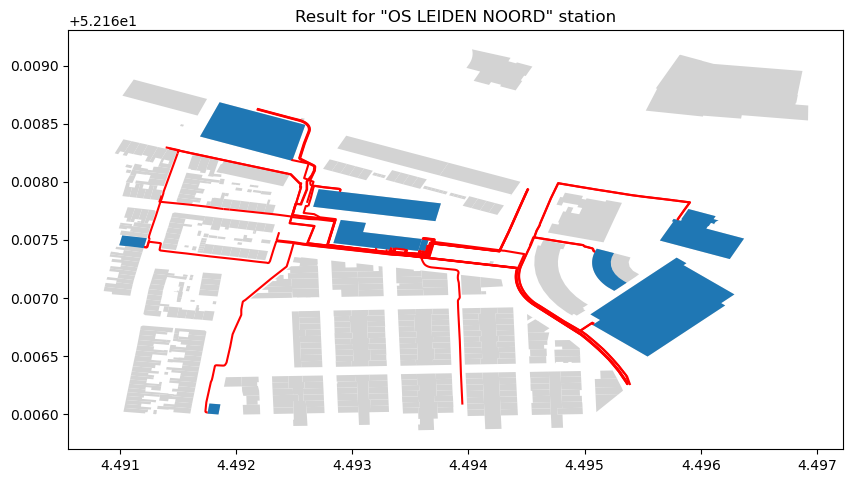

In [24]:
station_name = 'OS LEIDEN NOORD'
poi_idx = stations[stations.station == station_name].index[0]
foot_print = compiled_footprints[compiled_footprints.cluster == poi_idx]
before_foot_print = foot_prints[poi_idx]
area_of_interest = unary_union(foot_print.geometry)
minx, miny, maxx, maxy = area_of_interest.bounds
aoi_lines = ms[(ms.minx >= minx) & (ms.miny >= miny) & (ms.maxx <= maxx) & (ms.maxy <= maxy)]

size = 10
fig, ax = plt.subplots(figsize=(size, size))

ax.set_title(f'Result for "{station_name}" station')
aoi_lines.plot(ax=ax, color='red')
before_foot_print.plot(ax=ax, color='lightgrey')
foot_print.plot(ax=ax);

- Grey = footprints obtained from OSMNX
- Blue = pre-fine-tuned by the algorithm
- Red = mid-voltage'

Next:
- auto in-fine-tuning now that we have pre-fine-tuned data and substations geolocations
- manual post-fine-tuning which can be applied with ease since the rectangles return the referenced ID when selected. Thus, process is as follows -> only select the points of interest (per station), the remaining will be removed.

# - Phase 2

## After pre-fine-tuning we continue with auto in-fine-tuning building footprints given substations geolocations as targets and pre-fine-tuned data

In [9]:
compiled_footprints = gpd.read_file(os.path.join(ROOT, 'static', 'footprint_manual_selection.geojson'))

In [27]:
# A maximum distance determined after analysing a subset of distances
threshold = 0.198569 - 0.197542

# This func might be deprecated
def in_fine_tune_estimation(stations: gpd.GeoDataFrame, footprints: gpd.GeoDataFrame, threshold: float,
                            degree_threshold: int = 9) -> gpd.GeoDataFrame:
    fine_tuned_footprints = []

    for idx in range(len(stations)):
        station = stations.iloc[idx]
        d = station.geometry.distance(footprints.geometry).sort_values()

        # only retrieve buildings within a certain distance
        idx_candidates = d[d <= threshold].index
        candidates = footprints.iloc[idx_candidates]

        # only retrieve buildings that have at least a degree of 10
        candidates = candidates[candidates['degree'] > degree_threshold]

        fine_tuned_footprints.append(candidates)

    # Return a flattened result
    return gpd.GeoDataFrame([y for x in fine_tuned_footprints for y in x.values], columns=compiled_footprints.columns)

Our analysis shows that sub-stations have a degree centrality (deg) of at least 5 while non-sub-stations have $$deg < 5$$ This experimental approach might lead to removal of the func -> "in_fine_tune_estimation".

In [11]:
compiled_footprints['degree'] = compiled_footprints['cable_ms_idx'].apply(lambda x: len(x.split(',')))
compiled_footprints.head()

,cluster,osmids,cable_ms_idx,geometry,degree
0,96,267007724,"222386,222419,222438,222442,222696,226942,227181","POLYGON ((5.93482 52.67248, 5.93490 52.67251, ...",7
1,137,262061921,85135,"POLYGON ((6.13483 52.27709, 6.13491 52.27710, ...",1
2,137,262062281,85134,"POLYGON ((6.13539 52.27707, 6.13546 52.27708, ...",1
3,189,263897491,"72560,72827,72829","POLYGON ((4.62631 52.07806, 4.62634 52.07827, ...",3
4,189,263898090,"72261,280353","POLYGON ((4.62888 52.07729, 4.62885 52.07729, ...",2


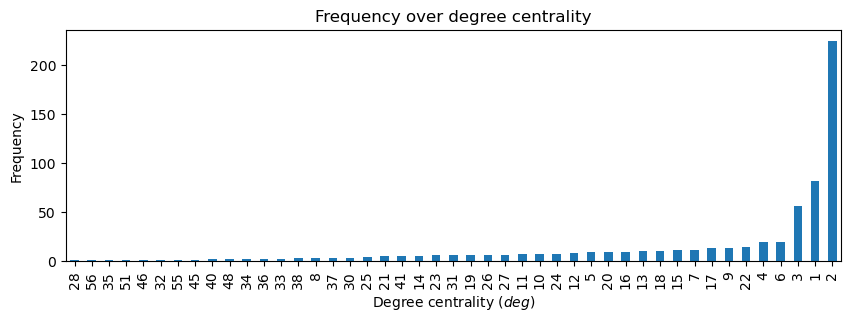

In [15]:
compiled_footprints.degree.value_counts().sort_values().plot.bar(figsize=(10, 3),
                                                                 title='Frequency over degree centrality',
                                                                 xlabel="Degree centrality $(deg)$", ylabel="Frequency");

In [44]:
%%time
# fined_tuned_footprints = in_fine_tune_estimation(stations, compiled_footprints, threshold, degree_threshold=9)
degree_threshold = 4
fined_tuned_footprints = compiled_footprints[compiled_footprints['degree'] > degree_threshold]

CPU times: user 1.56 ms, sys: 3.9 ms, total: 5.46 ms
Wall time: 5.42 ms


In [45]:
print(f'Fine-tuning result in dimensions, before: {compiled_footprints.shape} - after: {fined_tuned_footprints.shape}')

Fine-tuning result in dimensions, before: (618, 5) - after: (236, 5)


Plot the same sample as before after in-fine-tuning

In [46]:
station_name = 'OS LEIDEN NOORD'
poi_idx = stations[stations.station == station_name].index[0]

foot_print = compiled_footprints[compiled_footprints.cluster == poi_idx]
fine_tuned_foot_print = fined_tuned_footprints[fined_tuned_footprints.cluster == poi_idx]

before_foot_print = foot_prints[poi_idx]

area_of_interest = unary_union(foot_print.geometry)

minx, miny, maxx, maxy = area_of_interest.bounds
aoi_lines = ms[(ms.minx >= minx) & (ms.miny >= miny) & (ms.maxx <= maxx) & (ms.maxy <= maxy)]

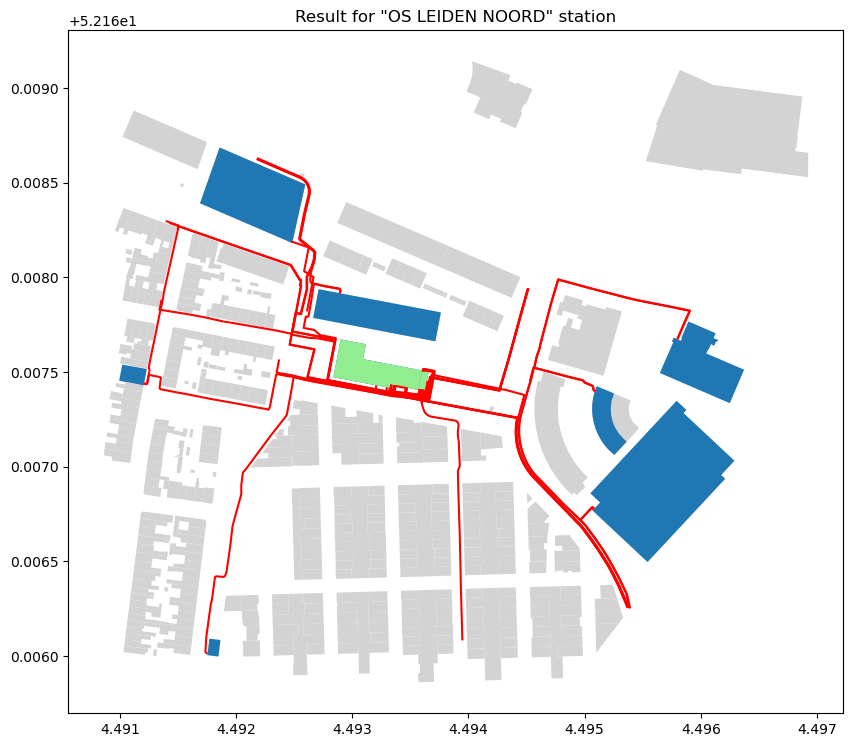

In [47]:
size = 10
fig, ax = plt.subplots(figsize=(size, size))

ax.set_title(f'Result for "{station_name}" station')
aoi_lines.plot(ax=ax, color='red')
before_foot_print.plot(ax=ax, color='lightgrey')
foot_print.plot(ax=ax)
fine_tuned_foot_print.plot(ax=ax, color='lightgreen');

- Grey = footprints obtained from OSMNX
- Blue = pre-fine-tuned by the algorithm
- Green = in-fine-tuned by the algorithm
- Red = mid-voltage'

---
**_NOTE:_**

The solution consists of 3 layers: Grey, Blue and Green
- Grey: depicts the building footprints within certain distance given point of interest
- Blue: depicts the pre-fine-tuning results consisting of building footprints that intersect with the power cables, excluding the Grey footprints
- Green: depicts the in-fine-tuning results consisting of the building footprints of the substation, excluding Grey and Blue footprints
---

Save solution

In [48]:
fined_tuned_footprints.to_file(os.path.join(ROOT, 'static', 'footprint_post_selection.geojson'), driver='GeoJSON')

# - Phase 3

## Post-fine-tuning building footprints, note this is a manual process as outlined before

In [3]:
fined_tuned_footprints = gpd.read_file(os.path.join(ROOT, 'static', 'footprint_post_selection.geojson'))
fined_tuned_footprints.head()

,cluster,osmids,cable_ms_idx,degree,geometry
0,96,267007724,"222386,222419,222438,222442,222696,226942,227181",7,"POLYGON ((5.93482 52.67248, 5.93490 52.67251, ..."
1,189,263898247,"71145,280334,280335,280336,280337,280338,28033...",11,"POLYGON ((4.63067 52.07822, 4.63067 52.07826, ..."
2,203,270920330,"3899,4394,4395,4396,4950,5614,5618,6089,15286,...",23,"POLYGON ((5.13293 51.80192, 5.13291 51.80202, ..."
3,203,270920694,"5973,131882,131945,131946,131955,131957,230759...",17,"POLYGON ((5.13221 51.80196, 5.13220 51.80202, ..."
4,203,462420091,"214476,214477,214495,214496,214497,214498,2301...",12,"POLYGON ((5.13204 51.80180, 5.13200 51.80201, ..."


Number of clusters

In [4]:
num_clusters = fined_tuned_footprints.cluster.unique().size

Evaluation and remaining points

In [6]:
from evaluation import tuned_result

tuned = tuned_result

print(np.sort(list(tuned.keys())))
len(tuned), f'{num_clusters - len(tuned)}/{num_clusters}'

[ 96 189 203 205 206 207 208 209 210 211 212 213 214 215 216 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 278 279 280 281 282 284 285 286 287 288 289 290 291 292 293 294 295 296
 297 298 299 301 302 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320 321 322 323 324 325 326 327 328 330 332 333 334 335 336
 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354
 355 356 357 358 359 360]


(150, '5/155')

In [8]:
to_post_fine_tune = fined_tuned_footprints[~fined_tuned_footprints.cluster.isin(list(tuned.keys()))]
to_post_fine_tune.head()

,cluster,osmids,cable_ms_idx,degree,geometry
20,217,267107712,"156315,156316,156317,156320,156369,156447",6,"POLYGON ((4.90502 52.37167, 4.90501 52.37167, ..."
21,217,268782280,"156315,156316,156317,156320,156369,156447",6,"POLYGON ((4.90513 52.37133, 4.90508 52.37137, ..."
22,217,268782569,"156318,156467,156490,156596,156761,156762,1567...",33,"POLYGON ((4.90627 52.37082, 4.90658 52.37055, ..."
113,283,281410803,"151552,151553,151559,152552,233500,241285,241288",7,"POLYGON ((4.96247 52.35490, 4.96248 52.35492, ..."
114,283,441605807,"200774,200775,200776,200777,200788,200808,2412...",12,"POLYGON ((4.96095 52.35476, 4.96076 52.35488, ..."


Save as geojson for evaluation of the results obtained from the algo

In [40]:
# footprint_post_selection.geojson
to_post_fine_tune.to_file(os.path.join(ROOT, 'static', 'footprint_TMP_selection.geojson'), driver='GeoJSON')

In [41]:
from folium import Popup

markers = []
cluster_names = list(to_post_fine_tune.cluster.astype(str).unique())
centroids = []

for c_id in to_post_fine_tune.cluster.unique():
    x = to_post_fine_tune[to_post_fine_tune.cluster == c_id]
    xx = unary_union(x.geometry).centroid.coords
    xx = list(xx)[0]
    xx = [xx[1], xx[0]]
    centroids.append(xx)

/opt/homebrew/Caskroom/miniforge/base/envs/tenet-challenge/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


In [42]:
pops = [Popup(n, show=True, sticky=True) for n in cluster_names]

In [43]:
from folium import plugins

nl_map = to_post_fine_tune.explore()
plugins.MarkerCluster(centroids, icons=pops).add_to(nl_map)

nl_map.save('explorer1.html')

In [44]:
pd.DataFrame({
    'cl_name': cluster_names,
    'centroids': [f'{x[0]}, {x[1]}' for x in centroids]
})

,cl_name,centroids
0,216,"52.36062525805882, 4.895259477722545"
1,217,"52.37078836111795, 4.906094652740804"
2,237,"52.3333669439778, 4.965568894300751"
3,249,"52.35828829194799, 4.908534355319868"
4,255,"52.316056603490445, 4.932224502835068"
5,259,"52.39847305, 4.903193249999999"
6,270,"52.33635824509308, 4.888537919909302"
7,283,"52.354603729868046, 4.961634543002786"
8,287,"52.2915178353418, 4.882799099148253"
9,303,"52.25697278820026, 4.792132428279921"


Collection of footprints that are missing. These footprints will be added to the final compiled data set. The additional polygons are created within Google My Maps and (later) the drawing function (newly added) in the webapp of this project

In [12]:
from shapely import wkt

In [ ]:
coords = wkt.loads([
    "POLYGON ((6.3782186 51.9034468, 6.3785271 51.90334, 6.3788167 51.9036635, 6.3785056 51.9037661, 6.3782186 51.9034468))",
"POLYGON ((6.2193487 52.1494345, 6.2193044 52.1493292, 6.2196799 52.1492675, 6.2197268 52.1493753, 6.2193487 52.1494345))",
"POLYGON ((5.7724696 52.3700687, 5.7725366 52.3700077, 5.7725802 52.3700265, 5.7725105 52.3700883, 5.7724696 52.3700687))",
"POLYGON ((5.4613136 52.3460253, 5.4613981 52.345953, 5.4614661 52.3459835, 5.4613837 52.3460554, 5.4613136 52.3460253))",
"POLYGON ((5.4591224 52.3459612, 5.4593014 52.3458035, 5.459402 52.3458473, 5.4592243 52.3460063, 5.4591224 52.3459612))",
"POLYGON ((5.5142288 52.498878, 5.514222 52.498798, 5.5143776 52.4987947, 5.514383 52.4988731, 5.5142288 52.498878))",
"POLYGON ((5.6614035 52.5186362, 5.6614263 52.5184142, 5.6621841 52.5184346, 5.6621613 52.5186566, 5.6614035 52.5186362))",
"POLYGON ((5.7616939 52.6836977, 5.7618025 52.6836481, 5.762115 52.6838969, 5.762005 52.6839465, 5.7616939 52.6836977))"
    ])

CRS = 4326

x = gpd.GeoDataFrame({
    'cluster_id': [276, 278, 321, 280, 280, 353, 286, 284, 246],
    'geometry': coords
}, crs=CRS)

# x.explore()

In [ ]:
gpd_189 = gpd.read_file("""{"type":"FeatureCollection","features":[{"id":"189","type":"Feature","properties":{},"geometry":{"coordinates":[[[4.630791323941196,52.07829627674704],[4.630789415084848,52.07827234442635],[4.631003588766475,52.07826061289157],[4.631005879393626,52.07828431058829],[4.630791323941196,52.07829627674704]]],"type":"Polygon"}}]}""", driver='GeoJSON')
# gpd_189.set_crs(4326).explore()

In [24]:
gpd_320 = gpd.read_file("""
{"type":"FeatureCollection","features":[{"id":"320","type":"Feature","properties":{},"geometry":{"coordinates":[[[4.649678075069801,52.35297300804908],[4.649704700963866,52.35297510649667],[4.649712431061772,52.35288303701381],[4.649687952417622,52.35288303701381],[4.649678075069801,52.35297300804908]]],"type":"Polygon"}},{"id":"dd4044d8e17bdddb600d5120bcc31fd1","type":"Feature","properties":{},"geometry":{"coordinates":[[[4.650517270627773,52.35295951810963],[4.650552886330644,52.35296088843458],[4.650554288523239,52.35289819602539],[4.650523440276487,52.35289888118862],[4.650517270627773,52.35295951810963]]],"type":"Polygon"}}]}
""")

gpd_320

,id,geometry
0,320,"POLYGON ((4.64968 52.35297, 4.64970 52.35298, ..."
1,dd4044d8e17bdddb600d5120bcc31fd1,"POLYGON ((4.65052 52.35296, 4.65055 52.35296, ..."


In [26]:
gpd_240 = gpd.read_file("""
{"type":"FeatureCollection","features":[{"id":"240","type":"Feature","properties":{},"geometry":{"coordinates":[[[4.855191181258135,52.34735178284248],[4.855194175152064,52.34730499375229],[4.85524207744939,52.34730560338261],[4.855238834064437,52.3473525448791],[4.855191181258135,52.34735178284248]]],"type":"Polygon"}}]}
""")
gpd_240

,id,geometry
0,240,"POLYGON ((4.85519 52.34735, 4.85519 52.34730, ..."


In [45]:
gpd_333 = gpd.read_file("""
{"type":"FeatureCollection","features":[{"id":"333","type":"Feature","properties":{},"geometry":{"coordinates":[[[4.738245078508982,52.281991241828706],[4.738414162031802,52.28189743127035],[4.7385634219695305,52.28199980247817],[4.738394921493182,52.28209254274131],[4.738245078508982,52.281991241828706]]],"type":"Polygon"}}]}
""")
gpd_333

,id,geometry
0,cdec3e6f7c7861fa2f9ea62e90a4cf75,"POLYGON ((4.73825 52.28199, 4.73841 52.28190, ..."


In [47]:
gpd_347 = gpd.read_file("""
{"type":"FeatureCollection","features":[{"id":"347","type":"Feature","properties":{},"geometry":{"coordinates":[[[4.8414698950427635,52.30554722016555],[4.841570923865959,52.30552914551242],[4.84153724759156,52.30545776200026],[4.84143584458667,52.30547675185613],[4.8414698950427635,52.30554722016555]]],"type":"Polygon"}},{"id":"347","type":"Feature","properties":{},"geometry":{"coordinates":[[[4.841235185181915,52.30544544064466],[4.841233844077891,52.30544185305354],[4.841239711409941,52.30544082802723],[4.841240884875987,52.30544451812102],[4.841235185181915,52.30544544064466]]],"type":"Polygon"}}]}
""")
gpd_347

,id,geometry
0,347,"POLYGON ((4.84147 52.30555, 4.84157 52.30553, ..."
1,347,"POLYGON ((4.84124 52.30545, 4.84123 52.30544, ..."


In [48]:
gpd_342 = gpd.read_file("""
{"type":"FeatureCollection","features":[{"id":"342","type":"Feature","properties":{},"geometry":{"coordinates":[[[4.947830280805107,52.29530673894169],[4.947910398037919,52.29522109346581],[4.947982436222759,52.295240034306175],[4.947898279465193,52.295326915015124],[4.947830280805107,52.29530673894169]]],"type":"Polygon"}}]}
""")
gpd_342

,id,geometry
0,342,"POLYGON ((4.94783 52.29531, 4.94791 52.29522, ..."


In [49]:
gpd_270 = gpd.read_file("""
{"type":"FeatureCollection","features":[{"id":"270","type":"Feature","properties":{},"geometry":{"coordinates":[[[4.8886239896999655,52.336406656007256],[4.8886239896999655,52.3363133888858],[4.88879530771041,52.3363133888858],[4.88879530771041,52.33640586894404],[4.8886239896999655,52.336406656007256]]],"type":"Polygon"}}]}
""")
gpd_270

,id,geometry
0,270,"POLYGON ((4.88862 52.33641, 4.88862 52.33631, ..."


In [50]:
gpd_237 = gpd.read_file("""
{"type":"FeatureCollection","features":[{"id":"237","type":"Feature","properties":{},"geometry":{"coordinates":[[[4.965493429167964,52.33301461080876],[4.965439846773592,52.33293621284852],[4.965470034037878,52.332929756539755],[4.965521352387185,52.33300769334713],[4.965493429167964,52.33301461080876]]],"type":"Polygon"}}]}
""")
gpd_237

,id,geometry
0,237,"POLYGON ((4.96549 52.33301, 4.96544 52.33294, ..."
